# SardiNIA Wave 5 - January 2019 release


```
From: Marco Masala <marco.masala@irgb.cnr.it>
Date: Wednesday, November 14, 2018 at 11:45 AM
To: "Coletta, Christopher (NIH/NIA/IRP) [E]" <chris.coletta@nih.gov>
Cc: "Schlessinger, David (NIH/NIA/IRP) [V]" <schlessingerd@grc.nia.nih.gov>, 
"Nagaraja, Ramaiah (NIH/NIA/IRP) [E]" <nagarajar@grc.nia.nih.gov>, 
Edoardo Fiorillo <edoardo.fiorillo@irgb.cnr.it>, Francesco Cucca <francesco.cucca@irgb.cnr.it>,
Michele Marongiu <michele.marongiu@irgb.cnr.it>
Subject: database uploaded
 
Dear Christopher,  
 
I uploaded a new version of the db in the usual folder of the ftp server: 
/home/sardinia/incoming/DbSardinia/20181108_dbSardinia5.zip 
 
We had problems exporting the HOLTER data, for this reason the HOLTER table is missing
in the database. We hope to solve the problem in the next few days and make an update 
of this release
 
I have not yet relived the CAROTID table from the doctor in charge and therefore it
is not present in the database.
 
I have not received any updates from the doctor responsible for the VASCULAR data. 
The table is present but has not been updated.
 
the tables SPHIGMOCOR_HRV, SPHIGMOCOR_PWA and SPHIGMOCOR_PWV were exported using the 
method you requested. Their structure does not coincide with those sent previously 
that were extracted directly from the database.
 
I have not yet received the ECOCARDIO data. ECOCARDIO visits, however, are not made 
at 5 wave visits, and follow a completely different calendar.  
 
The data of all the tables of this version replace those of the previous versions, 
in particular the tables BLOOD and BLOOD_2 have been checked again and some errors 
present in the old versions have been corrected.
 
Do not hesitate to contact me if you find any error or lack
 
best
Marco
```

# Load libraries and check versions

## Required external libraries
* mdbtools must be installed and on your %PATH% or \$PATH
    * https://github.com/brianb/mdbtools/
    * ```brew install mdbtools```
* Additional required Python libraries
    * PANDAS and NumPy, of course
    * PANDAS requires ```xlrd``` and ```xlwt``` for their ```read_excel``` functions
        * ```!pip3 install xlrd```
        * ```!pip3 install xlwt```

In [1]:
# Python version used
import sys
print( 'Python version', sys.version )

Python version 3.7.0 (default, Aug 22 2018, 15:22:56) 
[Clang 9.0.0 (clang-900.0.39.2)]


In [2]:
# Load from Python standard library
from subprocess import check_output
from io import BytesIO
from collections import Counter
import time
t00 = time.time()
from pathlib import Path
# Make a pretty printer
from pprint import PrettyPrinter
pp = PrettyPrinter( width=100, compact=True )

In [3]:
# PANDAS
import pandas as pd
print( 'PANDAS version', pd.__version__ )

PANDAS version 0.23.4


In [4]:
# NumPy
import numpy as np
print( 'NumPy version', np.__version__ )

NumPy version 1.15.4


In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
def full_frame(width=None, height=None):
    import matplotlib as mpl
    mpl.rcParams['savefig.pad_inches'] = 0
    figsize = None if width is None else (width, height)
    fig = plt.figure(figsize=figsize)
    ax = plt.axes([0,0,1,1], frameon=False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.autoscale(tight=True)

# Input files

* ```ita_db``` - Sardinian database file (Microsoft Access .mdb format)
* ```ita_db_desc``` - Sardinian database description file (Microsoft Excel .xlsx format)
* ```us_db``` - NIA database, most recent "Public Release File" (PRF) (tab-separated test file)
* ```us_db_desc``` - NIA database description file (Microsoft Excel .xlsx format)
* ```name_map``` - Column name mapping spreadsheet (Microsoft Excel .xlsx format)
    * Like a phonebook mapping ITA column names to US column names
    * Only names mapped in this file will end up in the output merged database
    * The code later on will complain about missing columns unless the corresponding row has value of "yes" in the "ignore" column within the mapping file.

## Paths

In [6]:
pwd

'/Users/colettace/projects/david/sardiNIA_database/latest/January2019_Wave5_Update'

In [7]:
paths = {}

In [8]:
paths['ita_db'] = Path('DbSardinia_20181108.mdb')

In [9]:
paths['ita_db_desc'] = Path( 'DbDescription5.xlsx' )

In [10]:
paths['us_db'] = Path( '20180801_SardiNIA_WaveI-V.txt' )

In [11]:
paths['us_db_desc'] = Path( '20190111-Sardinia-Data-Description.xls' )

In [12]:
paths['name_map'] = Path( '20190111-Sardinia-ITA2ENG-Trait-Dictionary.xlsx' )

In [13]:
all( [ _.exists() for _ in paths.values() ] )

True

In [14]:
paths = { n: str(p) for n, p in paths.items() }

## Load Sardinian database

### Get names of tables

In [21]:
cmd = [ 'mdb-tables', paths['ita_db'] ]

In [22]:
table_names = check_output( cmd ).decode().strip().split()

In [23]:
table_names = sorted( table_names )

In [24]:
len(table_names)

22

In [25]:
pp.pprint( table_names )

['AUDIOMETRY', 'BLOOD', 'BLOOD_2', 'DISEASES', 'DISEASESCHECKLIST_n', 'ECG', 'EXAMINATION',
 'EXAMINATION_BIS', 'INDIVIDUAL', 'MEDHISTORY', 'MEDICATIONS', 'MMSE', 'OTHERMEDICATION2_NEW',
 'OTHERMEDICATIONS', 'PHYSICAL_ACTIVITY', 'PHYSICAL_TEST', 'SPHIGMOCOR_HRV', 'SPHIGMOCOR_PWA',
 'SPHIGMOCOR_PWV', 'SPIROMETER', 'URINE', 'VASCULAR']


In [26]:
table_names.remove( "OTHERMEDICATIONS")
table_names.remove('SPHIGMOCOR_PWV' )
table_names.remove('SPHIGMOCOR_HRV')
table_names.remove('SPHIGMOCOR_PWA')

### Read tables, dropping any empty columns 

In [27]:
def pull_table( table_name, path=None ):
    if path is None:
        path = paths['ita_db']
    cmd = [ 'mdb-export', path, table_name ]
    raw_output = check_output( cmd )
    return pd.read_csv( BytesIO( raw_output ) )

In [28]:
tables = { n: pull_table(n).dropna( axis=1, how='all') for n in table_names }

### Special tables

In [31]:
for n in ['SPHIGMOCOR_PWV', 'SPHIGMOCOR_HRV', 'SPHIGMOCOR_PWA']:
    tables[n] = pd.read_csv( f"20190123_{n}_merged.csv" )

In [43]:
tables['HOLTER'] = pull_table( 'HOLTER', '20180406_dbSardinia5.mdb')

### Drop empty rows, i.e., ones with ID_INDIVIDUAL filled, but that's it

In [45]:
empty_row_counts = {}
for n, df in tables.items():
    empty_row_indices = df[df.count(axis=1) == 1].index
    df.drop( index=empty_row_indices, inplace=True )
    print( f"{n}: dropped {len(empty_row_indices)} rows.")
    empty_row_counts[n] = len(empty_row_indices)

AUDIOMETRY: dropped 270 rows.
BLOOD: dropped 21 rows.
BLOOD_2: dropped 74 rows.
DISEASES: dropped 15 rows.
DISEASESCHECKLIST_n: dropped 15 rows.
ECG: dropped 0 rows.
EXAMINATION: dropped 7 rows.
EXAMINATION_BIS: dropped 4 rows.
INDIVIDUAL: dropped 0 rows.
MEDHISTORY: dropped 15 rows.
MEDICATIONS: dropped 15 rows.
MMSE: dropped 2446 rows.
OTHERMEDICATION2_NEW: dropped 0 rows.
PHYSICAL_ACTIVITY: dropped 15 rows.
PHYSICAL_TEST: dropped 9 rows.
SPIROMETER: dropped 1975 rows.
URINE: dropped 192 rows.
VASCULAR: dropped 744 rows.
SPHIGMOCOR_PWV: dropped 0 rows.
SPHIGMOCOR_HRV: dropped 0 rows.
SPHIGMOCOR_PWA: dropped 0 rows.
HOLTER: dropped 1673 rows.


## Load Sardinian database description file

In [46]:
ita_db_description = pd.read_excel( paths['ita_db_desc'] )

In [47]:
ita_db_description.shape

(861, 5)

## Load NIA database

In [48]:
old_prf = pd.read_csv( paths['us_db'] , sep='\t' )

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (21,22,23,24,25,30,31,73,74,77,78,81,82,98,102,106,107,115,341,395,396,926) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [49]:
old_prf.shape

(23232, 1337)

## Load NIA database description file

In [50]:
us_db_description = pd.read_excel( paths['us_db_desc'] )

In [51]:
us_db_description.shape

(1373, 6)

## Load column name mapping spreadsheet

In [52]:
field_name_map = pd.read_excel( paths['name_map'] )

In [53]:
field_name_map.shape

(1470, 6)

In [54]:
field_name_map = field_name_map[ field_name_map.ignore == 'no'].copy()

In [55]:
# drop ignore column
field_name_map.drop( 'ignore', axis=1, inplace=True )

In [56]:
field_name_map.drop( 'Unnamed: 5', axis=1, inplace=True )

In [57]:
field_name_map.shape

(1314, 4)

In [58]:
#pprint(ita2us_field_name_map)

# Input file audit

Across all 5 input files, look for:
* Missing tables
* Missing columns
* Column name mismatches, i.e., sometimes the columns names change

Based on output of the following section you can:
* Drop certain columns in certain circumstances after making sure they're not important
* If columns ARE important, add them to the name mapping excel sheet and rerun this entire notebook

## Any missing tables?

In [59]:
expected_ita_tables = sorted( field_name_map['ita_prefix'].unique() )

In [61]:
set( expected_ita_tables ) - set( tables.keys() )

{'CAROTID', 'ECARDIO'}

## Column comparison 1: Sardinian DB <-> NIA DB

In [62]:
table_shapes = { n: t.shape for n, t in tables.items() }

In [63]:
unique_IDindivs = { n: len( t['ID_INDIVIDUAL'].unique() ) 
                        for n, t in tables.items() }

In [70]:
ita_fields = { n: list( t.columns ) for n, t in tables.items() }

In [71]:
conversion_tables = dict(list( field_name_map.groupby( 'ita_prefix' ) ) )
# Reorder and filter
conversion_tables = { n: conversion_tables[ n ] for n in tables.keys() }

In [72]:
ita2us_table_name_map = { n: df['eng_prefix'].iloc[0] 
                         for n, df in conversion_tables.items() }

In [73]:
itaDB_fields_matched2_engDB = { n: set(l) & set( conversion_tables[n]['ita'] ) 
                                  for n, l in ita_fields.items() }

In [74]:
itaDB_fields_not_matched2_engDB = { n: set(l) - set( conversion_tables[n]['ita']) 
                              for n, l in ita_fields.items() }

In [75]:
ita2us_field_name_map = { n: dict( list( conversion_tables[n][['ita', 'eng']].itertuples(index=None,name=None) ) )
                              for n, df in conversion_tables.items() }

In [76]:
def ENG2ITA_set_diff( table_name, name_list ):
    return set( conversion_tables[ table_name ]['eng'] ) - \
        set( [ ita2us_field_name_map[ table_name ].get( _, None ) for _ in name_list ] )

In [77]:
engDB_fields_not_matched2_itaDB = { n: ENG2ITA_set_diff(n, l) for n, l in ita_fields.items() }

In [78]:
# pp.pprint( engDB_fields_not_matched2_itaDB )

In [79]:
for s in itaDB_fields_not_matched2_engDB.values():
    s.discard( 'ID_INDIVIDUAL' )

## Column comparison 2: Sardinian DB <-> Sardinian DB Description

In [80]:
itaDB_fields_matched2_itaDB_DESC = { 
    n: set(l) & set( ita_db_description.loc[ ita_db_description['TABLE'] == n, 'FIELD'] ) 
        for n, l in ita_fields.items() }

In [81]:
#pprint(itaDB_fields_matched2_itaDB_DESC, width=160, compact=True)

In [82]:
itaDB_fields_not_matched2_itaDB_DESC = { 
    n: set(l) - set( ita_db_description.loc[ ita_db_description['TABLE'] == n, 'FIELD'] ) 
        for n, l in ita_fields.items() }

## Column Mismatch Report: general stats

In [83]:
stat_data = { 'eng_table_name': ita2us_table_name_map,
             'size': table_shapes,
             'unique_indivs': unique_IDindivs, 
             'itaDB_matched_engDB': {n: len(l) for n, l in itaDB_fields_matched2_engDB.items()},
             'itaDB_unmatched_engDB': {n: len(l) for n, l in itaDB_fields_not_matched2_engDB.items()},
             'engDB_unmatched_itaDB': {n: len(l) for n, l in engDB_fields_not_matched2_itaDB.items()},
             'itaDB_unmatched_itaDB_DESC': {n: len(l) for n, l in itaDB_fields_not_matched2_itaDB_DESC.items()},
            }

In [84]:
stat_data = pd.DataFrame.from_dict( stat_data )

In [85]:
stat_data[['rows', 'cols']] = stat_data['size'].apply(pd.Series)

In [86]:
stat_data['DB_discrepancy'] = (stat_data['itaDB_unmatched_engDB'] + stat_data['engDB_unmatched_itaDB']).astype(bool)

In [87]:
stat_data = stat_data.reindex( 
    index=expected_ita_tables,
    columns=['eng_table_name', 'rows', "unique_indivs", "cols",
            "itaDB_matched_engDB", 'itaDB_unmatched_engDB', 
            'engDB_unmatched_itaDB', 'DB_discrepancy', 
           "itaDB_unmatched_itaDB_DESC"] )

In [88]:
stat_data

,eng_table_name,rows,unique_indivs,cols,itaDB_matched_engDB,itaDB_unmatched_engDB,engDB_unmatched_itaDB,DB_discrepancy,itaDB_unmatched_itaDB_DESC
AUDIOMETRY,audio,2857.0,2857.0,15.0,14.0,0.0,0.0,False,15.0
BLOOD,labs,3106.0,3106.0,40.0,39.0,0.0,14.0,True,2.0
BLOOD_2,labs2_,3053.0,3053.0,37.0,36.0,0.0,0.0,False,0.0
CAROTID,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DISEASES,dis,3112.0,3112.0,171.0,170.0,0.0,4.0,True,171.0
DISEASESCHECKLIST_n,disChk,3112.0,3112.0,94.0,93.0,0.0,44.0,True,94.0
ECARDIO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ECG,ecg,3127.0,3127.0,21.0,20.0,0.0,0.0,False,1.0
EXAMINATION,exm,3120.0,3120.0,29.0,28.0,0.0,0.0,False,2.0
EXAMINATION_BIS,examBis,3123.0,3123.0,37.0,34.0,2.0,5.0,True,4.0


## Column Mismatch Report: list unmatched fields

In [90]:
for n in tables.keys():
    if not stat_data.loc[ n, 'DB_discrepancy']:
        continue

    pp.pprint({ n : { 
        "Sard DB": itaDB_fields_not_matched2_engDB[n],
        "NIA DB": engDB_fields_not_matched2_itaDB[n],
        "Sard DBdesc": itaDB_fields_not_matched2_itaDB_DESC[n],
        #"Sard DB counts": "\n"+str(tables[n].count()[ itaDB_fields_not_matched2_engDB[n] ])
    }})

{'BLOOD': {'NIA DB': {'labsAta', 'labsAtg', 'labsBilirubinad', 'labsBilirubinat', 'labsG6PD',
                      'labsHBA2', 'labsHBF', 'labsHbA1C', 'labsHbA1Cdx', 'labsPCR',
                      'labsPotassiemia', 'labsSodiemia', 'labsTie', 'labsZnPP'},
           'Sard DB': set(),
           'Sard DBdesc': {'CALCIO', 'ALBUMINA'}}}
{'DISEASES': {'NIA DB': {'disCancerBones', 'disExpr1079', 'disMooddisorders', 'disExpr1080'},
              'Sard DB': set(),
              'Sard DBdesc': {'ACROMEGALY', 'ALPHA', 'ALZHEIMER', 'ANGINA_PECTORIS_1',
                              'ANGINA_PECTORIS_2', 'ANGINA_PECTORIS_3', 'ANGINA_PECTORIS_4',
                              'ANKYLOSING', 'ARTHRITIS', 'ASTHMA', 'ASTIGMATISM', 'BIPOLAR',
                              'BRONCHITIS', 'B_HETEROZIGOTE', 'B_HOMOZIGOTE', 'CATARACT',
                              'CIRRHOSIS', 'COLITIS', 'COLORBLIND', 'CROHN', 'DEMENTIAS',
                              'DEPRESSIVE', 'DIABETES', 'DIABETES_1', 'DIABETES_2'

## Drop columns in certain circumstances

In [91]:
for n in table_names:
    if any( n == _ for _ in ['SPHIGMOCOR_PWV', 'SPHIGMOCOR_HRV', 'SPHIGMOCOR_PWA'] ):
        # I've checked, and the leftover columns don't matter
        drop_these = itaDB_fields_not_matched2_engDB[n]-set(['DATETIME'])
        print( f"{n}: dropping these: {drop_these}" )
        tables[n].drop( columns=, inplace=True )

## OPTIONAL: Import individual IDs from another notebook for comparison

In [ ]:
new_indivs = { n: set( t['ID_INDIVIDUAL'] ) for n, t in tables.items() }

In [ ]:
%store -r old_indivs

In [ ]:
for n in sorted( list( set(new_indivs.keys()) | set(old_indivs.keys()) )):
    old = old_indivs.get( n, set() )
    new = new_indivs.get( n, set() )

    print( f"{len( old - new)}\t{len( new - old)}\t{len( new & old )}\t{n}")

In [ ]:
pp.pprint( old_indivs["SPHIGMOCOR_HRV"] - new_indivs["SPHIGMOCOR_HRV"] )

In [ ]:
tables['VASCULAR'].count()

# Handle SphygmoCor Tables
## Pre-merge quality control

* compare these SphigmoCor tables to tables from last upload

In [92]:
ls -l *.mdb

-rw-r--r--  1 colettace  1360859114  10747904 Jan 22 15:19 20180406_dbSardinia5.mdb
-rw-r--r--  1 colettace  1360859114  21254144 Nov 14 16:56 DbSardinia_20181108.mdb


In [93]:
tables['SPHIGMOCOR_HRV'].shape

(2319, 60)

## SphygmoCor PWA Quality Control

* Drop certain readings based on QC metrics given to us by SphygmoCor technicians

In [94]:
pwa_qc_cols = ['ID_INDIVIDUAL', 'DATETIME', 'P_QC_PH', 'P_QC_PHV', 'P_QC_DV', 'P_MAX_DPDT' ]

In [95]:
sph_df = tables["SPHIGMOCOR_PWA"]

In [96]:
sph_df.shape

(4837, 83)

In [97]:
tables["SPHIGMOCOR_PWA"].columns

Index(['ID_INDIVIDUAL', 'data visita 5', 'diff', 'DATETIME', 'SP', 'DP', 'HR',
       'ED', 'CalcED', 'QUALITY_ED', 'P_SP', 'P_DP', 'P_MEANP', 'P_T1', 'P_T2',
       'P_QUALITY_T1', 'P_QUALITY_T2', 'P_P1', 'P_P2', 'P_T1ED', 'P_T2ED',
       'P_AI', 'P_ESP', 'P_MAX_DPDT', 'P_QC_PH', 'P_QC_PHV', 'P_QC_PLV',
       'P_QC_DV', 'C_SP', 'C_DP', 'C_MEANP', 'C_T1', 'C_T2', 'C_QUALITY_T1',
       'C_QUALITY_T2', 'C_P1', 'C_P2', 'C_T1ED', 'C_T2ED', 'C_AI', 'C_ESP',
       'C_AP', 'C_MPS', 'C_MPD', 'C_TTI', 'C_DTI', 'C_SVI', 'C_PERIOD', 'C_DD',
       'C_ED_PERIOD', 'C_DD_PERIOD', 'C_PH', 'C_P1_HEIGHT', 'C_AGPH', 'C_AL',
       'C_ATI', 'version', 'System ID', 'Database ID', 'Patient Number',
       'Patient Notes', 'MP', 'DATA_REV', 'AGE', 'HEIGHT', 'WEIGHT',
       'BODY_MASS_INDEX', 'SAMPLE_RATE', 'SIMULATION MODE',
       'Tonometer Serial Number', 'SUB_TYPE', 'Inconclusive', 'Reference Age',
       'PPAmpRatio', 'P_QC_SDEV', 'Operator Index', 'P_CalcT1', 'P_CalcT2',
       'C_AP_HR75', 'C_AG

In [98]:
qc_df = sph_df.reindex( columns=pwa_qc_cols ).copy()

In [99]:
qc_df.shape

(4837, 6)

In [100]:
qc_df.head()

,ID_INDIVIDUAL,DATETIME,P_QC_PH,P_QC_PHV,P_QC_DV,P_MAX_DPDT
0,7,06/17/16 15:30:51,142.875000,2.719016,1.684165,875.549988
1,7,06/17/16 15:31:14,131.555557,3.797341,4.413006,853.174988
2,8,07/26/17 11:26:41,85.000000,5.000000,3.000000,633.000000
3,8,07/26/17 11:26:59,87.000000,2.000000,3.000000,633.000000
4,14,04/12/17 09:35:16,102.656250,2.945026,5.053272,944.760925


In [101]:
len( sorted( qc_df.ID_INDIVIDUAL.unique() ) )

2244

In [102]:
# Pulse height failure
qc_df[ 'P_QC_PH_FAIL' ] = qc_df['P_QC_PH'] < 80
# Pulse Height Variation Failure
qc_df[ 'P_QC_PHV_FAIL' ] = qc_df['P_QC_PHV'] > 5
# Diastolic Variation Failure
qc_df[ 'P_QC_DV_FAIL' ] = qc_df['P_QC_DV'] > 5
# dP/dt Failure
qc_df[ 'P_MAX_DPDT_FAIL' ] = \
    ( qc_df['P_MAX_DPDT'] < 350) | (qc_df['P_MAX_DPDT'] > 1650 ) 

# 9999 failure
qc_df[ '9999_FAIL' ] = sph_df.apply( lambda row: 9999 in list(row), axis=1)
# Failure for any reason
qc_df[ 'ANY_REASON_FAIL'] = \
    qc_df[ 'P_QC_PH_FAIL' ] | qc_df[ 'P_QC_PHV_FAIL' ] | \
    qc_df[ 'P_QC_DV_FAIL' ] | qc_df[ 'P_MAX_DPDT_FAIL' ] \
    | qc_df[ '9999_FAIL' ]
# Failure for any reason except dP/dt
qc_df[ 'NON_DPDT_FAIL'] = \
    qc_df[ 'P_QC_PH_FAIL' ] | qc_df[ 'P_QC_PHV_FAIL' ] | \
    qc_df[ 'P_QC_DV_FAIL' ] | qc_df[ '9999_FAIL' ]

In [103]:
print( f"Total input row count: {len( sph_df )}" )
print( f"Unique individual count: {len( sph_df['ID_INDIVIDUAL'].unique() )}" )
c = Counter( c for _id, c in Counter( list(sph_df['ID_INDIVIDUAL']) ).items() )
print( "Observation counts", c )

nfail = qc_df[ 'ANY_REASON_FAIL'].sum()
nrows = len(qc_df)
print( f"Num failures for any reason: {nfail} out of {nrows}, {(nrows-nfail)/nrows*100:0.1f}% success" )

qc_df_non_fail = qc_df[ ~qc_df[ 'ANY_REASON_FAIL'] ].copy()
print( "Num unique individuals with at least 1 failure:", len( qc_df_non_fail['ID_INDIVIDUAL'].unique()) )

Total input row count: 4837
Unique individual count: 2244
Observation counts Counter({2: 1936, 3: 225, 4: 55, 1: 18, 5: 8, 6: 2})
Num failures for any reason: 1619 out of 4837, 66.5% success
Num unique individuals with at least 1 failure: 1892


In [104]:
nfail_nondpdt = qc_df[ 'NON_DPDT_FAIL'].sum()

In [105]:
qc_df_non_fail_dpdt = qc_df[ ~qc_df[ 'NON_DPDT_FAIL'] ].copy()
print( f"Num failures not due to dP/dt: {nfail_nondpdt} out of {nrows}, {(nrows-nfail_nondpdt)/nrows*100:0.1f}% success" )
print( "Num unique individuals with at least 1 failure NOT due to dP/dt", len( qc_df_non_fail_dpdt['ID_INDIVIDUAL'].unique() ) )

Num failures not due to dP/dt: 1585 out of 4837, 67.2% success
Num unique individuals with at least 1 failure NOT due to dP/dt 1909


In [106]:
# Only include failed dp/dt if individual would be excluded otherwise
# Keep only those observations if they are one of the individuals we would lose 
# if we used the "fail for any reason" criterion.
rescue_these_individuals = \
    set( qc_df_non_fail_dpdt['ID_INDIVIDUAL'] ) - set( qc_df_non_fail['ID_INDIVIDUAL'] )

difference_record_indices = set( qc_df_non_fail_dpdt.index) - set( qc_df_non_fail.index )

rescued = qc_df_non_fail_dpdt.loc[ qc_df_non_fail_dpdt.index.isin( difference_record_indices ) & \
                    qc_df_non_fail_dpdt.ID_INDIVIDUAL.isin( rescue_these_individuals ) ]

print( "Rescued {} observations for {} individuals that would have been lost for dP/dt criterion".format(
    len(rescued), len(rescue_these_individuals) ) )

Rescued 27 observations for 17 individuals that would have been lost for dP/dt criterion


In [107]:
qc_df_non_fail = pd.concat( (qc_df_non_fail, rescued), axis=0, sort=False)

c = Counter( c for _id, c in Counter( list( qc_df_non_fail['ID_INDIVIDUAL']) ).items() )
print( "Non-fail Observation", c )
print( "Final non-fail obs count", len(qc_df_non_fail))
print( "Final non-fail obs count UNIQUE", len( qc_df_non_fail['ID_INDIVIDUAL'].unique()) )   

wanted_indices = qc_df_non_fail.index
del qc_df_non_fail, qc_df_non_fail_dpdt, qc_df, rescued

Non-fail Observation Counter({2: 1300, 1: 593, 3: 12, 4: 4})
Final non-fail obs count 3245
Final non-fail obs count UNIQUE 1909


In [108]:
tables["SPHIGMOCOR_PWA"] = tables["SPHIGMOCOR_PWA"].loc[ wanted_indices ]

print( tables["SPHIGMOCOR_PWA"].shape)

(3245, 83)


## Convert DATETIME strings in SphygmoCor tables to DATE datetime64 objects

In [109]:
for sph_table in ['SPHIGMOCOR_PWA', "SPHIGMOCOR_PWV", "SPHIGMOCOR_HRV"]:
    tables[sph_table]['DATE'] = pd.to_datetime( tables[sph_table]['DATETIME'] ).dt.date
    tables[sph_table] = tables[sph_table].drop( columns=['DATETIME'] )

## Merge multiple SphygmoCor readings into single row

* Use ```FirstM_``` and ```SecondM_``` infix

In [110]:
def CollapseSphygmoCorTable( sph_df, prefix ):
    t0 = time.time()
    case_count = []
    new_rows = []
    for _id, indiv_subset_df in iter( sph_df.groupby('ID_INDIVIDUAL') ):
        n_dates = len( indiv_subset_df.DATE.unique() )
        if len( indiv_subset_df ) == 1: # case 1: '1 date, 1 reading'
            # one observation, leave second blank
            case_count.append( 1 )
            # get a pd.Series object by calling iloc
            data = indiv_subset_df.iloc[0]
            data['N_Measurements'] = 1
            data.index = [ prefix + "FirstM_" + str(_) if _ != 'ID_INDIVIDUAL' else _ for _ in data.index ]
            new_rows.append( data )
        elif n_dates == 1: # Case 2: "1 date, >1 reading"
            # average these and leave second reading blank
            case_count.append( 2 )
            
            data_date = indiv_subset_df.DATE.unique()[0]
            orig_len = len( indiv_subset_df )
            # drop DATETIME column if it's there, and take the mean
            data = indiv_subset_df.mean( axis=0 )
            # have to add the date back in after mean()
            data['DATE'] = data_date
            data['N_Measurements'] = orig_len
            data.index = [ prefix + "FirstM_" + str(_) if _ != 'ID_INDIVIDUAL' else _ for _ in data.index ]
            new_rows.append( data )
        else:
            # If you've made it here there are at least 2 dates to deal with
            dates_groups = list( iter( indiv_subset_df.groupby('DATE') ) )
            
            if len( indiv_subset_df ) == 2 and n_dates == 2:
                # one reading per day - the nominal case
                case_count.append( 3 )
            elif len( dates_groups ) > 2:
                case_count.append( 5 )
            else:
                case_count.append( 4 )

            # take the 2 most recent
            first_date, first = dates_groups[-2]
            orig_first_len = len(first)
            first = first.mean( axis=0 )
            # have to add the date back in after mean()
            first['DATE'] = first_date
            first['N_Measurements'] = orig_first_len
            first.index = [ prefix + 'FirstM_' + str(_) if _ != 'ID_INDIVIDUAL' else _ for _ in first.index ]

            second_date, second = dates_groups[-1]         
            second_first_len = len(second)
            # print( set(second.columns) - set( second.mean( axis=0 ).index ) )
            second = second.mean( axis=0 )

            second['DATE'] = second_date
            second['N_Measurements'] = second_first_len

            second.index = [ prefix + 'SecondM_' + str(_) if _ != 'ID_INDIVIDUAL' else _ for _ in second.index ]
            # Don't need ID_INDIVIDUAL in the row twice
            data = pd.concat( ( first, second.drop( 'ID_INDIVIDUAL' ) ), axis=0, sort=False )

            new_rows.append( data ) 

    scenario_descriptions = { 1: '1 date, 1 reading', 2: "1 date, >1 reading",
      3: "2 dates, 1 reading/day", 4: "2 dates, >1 reading/day", 5: ">2 dates" }
    print( "Count\tScenario" )
    for scenario, count in Counter(case_count).items():
        print( count, '\t', scenario_descriptions[ scenario ] )
    retval = pd.concat( new_rows, axis=1, sort=False ).T
    
    # For some reason doesn't come through as numeric, but rather as object, try to downcast
    for col in retval.columns:
        try:
            retval[col] = pd.to_numeric( retval[col] )
        except:
            try:
                retval[col] = pd.to_datetime(retval[col])
            except:
                print( "Can't convert column '{}' to numeric or datetime".format( col ))

    # reindex
    retval.index = list(range(len(retval)))
    print( f"Operation took {time.time()-t0:0.1f} seconds." )
    return retval

### Merge SphygmoCor PWA table

In [111]:
test = CollapseSphygmoCorTable( tables['SPHIGMOCOR_PWA'], prefix='SphPWA' )

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/pandas/core/series.py:915: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc[key] = value


Count	Scenario
1307 	 1 date, >1 reading
593 	 1 date, 1 reading
7 	 2 dates, >1 reading/day
2 	 2 dates, 1 reading/day
Can't convert column 'SphPWAFirstM_Database ID' to numeric or datetime
Can't convert column 'SphPWAFirstM_Patient Notes' to numeric or datetime
Can't convert column 'SphPWAFirstM_SIMULATION MODE' to numeric or datetime
Can't convert column 'SphPWAFirstM_SUB_TYPE' to numeric or datetime
Can't convert column 'SphPWAFirstM_Inconclusive' to numeric or datetime
Can't convert column 'SphPWAFirstM_Reference Age' to numeric or datetime
Operation took 40.9 seconds.


In [ ]:
#pd.set_option('display.max_columns', len(test.columns))

In [ ]:
#pd.set_option('display.max_rows', len(test))

In [ ]:
#test.dtypes

In [112]:
test.SphPWAFirstM_N_Measurements.value_counts()

2    1302
1     598
3       9
Name: SphPWAFirstM_N_Measurements, dtype: int64

In [113]:
tables['SPHIGMOCOR_PWA'] = test

### Merge SphygmoCor PWV table

#### PWV: Create SUBTYPE dummy variables

* "CAROTID" -> 0
* "FEMORAL" -> 1

In [114]:
tables['SPHIGMOCOR_PWV']['A_SUBTYPE'].value_counts()

CAROTID    7351
FEMORAL       4
Name: A_SUBTYPE, dtype: int64

In [115]:
tables['SPHIGMOCOR_PWV']['A_SUBTYPE'] = \
    [0 if _ =='CAROTID' else 1 for _ in tables['SPHIGMOCOR_PWV']['A_SUBTYPE'].values]

In [116]:
tables['SPHIGMOCOR_PWV']['A_SUBTYPE'].value_counts()

0    7351
1       4
Name: A_SUBTYPE, dtype: int64

In [117]:
tables['SPHIGMOCOR_PWV']['B_SUBTYPE'].value_counts()

FEMORAL    7351
CAROTID       4
Name: B_SUBTYPE, dtype: int64

In [118]:
tables['SPHIGMOCOR_PWV']['B_SUBTYPE'] = \
    [0 if _ =='CAROTID' else 1 for _ in tables['SPHIGMOCOR_PWV']['B_SUBTYPE'].values]

In [119]:
tables['SPHIGMOCOR_PWV']['B_SUBTYPE'].value_counts()

1    7351
0       4
Name: B_SUBTYPE, dtype: int64

In [120]:
test = CollapseSphygmoCorTable( tables['SPHIGMOCOR_PWV'], prefix='SphPWV')

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


Count	Scenario
2235 	 1 date, >1 reading
13 	 2 dates, >1 reading/day
12 	 1 date, 1 reading
Operation took 15.5 seconds.


In [121]:
#test.head()

In [122]:
tables['SPHIGMOCOR_PWV'] = test

### Merge SphygmoCor HRV table

In [123]:
test = CollapseSphygmoCorTable( tables['SPHIGMOCOR_HRV'], prefix='SphHRV' )

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


Count	Scenario
2249 	 1 date, 1 reading
8 	 2 dates, 1 reading/day
23 	 1 date, >1 reading
1 	 >2 dates
Can't convert column 'SphHRVFirstM_Database ID' to numeric or datetime
Can't convert column 'SphHRVFirstM_Patient Notes' to numeric or datetime
Can't convert column 'SphHRVFirstM_SIMULATION MODE' to numeric or datetime
Operation took 90.1 seconds.


In [ ]:
#test.head()

In [124]:
tables['SPHIGMOCOR_HRV'] = test

# Drop all age columns except the one for this visit

In [125]:
tables['INDIVIDUAL'].columns

Index(['ID_INDIVIDUAL', 'ID_SIR', 'ID_MAD', 'birth_date', 'AGE_1', 'AGE_2',
       'AGE_3', 'AGE_4', 'AGE_5', 'SEX', 'EDUCATION', 'OCCUPATION',
       'MARITAL_ST', 'Cod_Sard', 'data visita 1', 'data visita 2',
       'data visita 3', 'data visita 4', 'data visita 5', 'visita'],
      dtype='object')

In [126]:
tables['INDIVIDUAL'].drop( columns=['AGE_1', 'AGE_2', 'AGE_3', 'AGE_4'], inplace=True )

# Reindex all tables to ID_INDIVIDUAL

Make sure each row is unique to an individual

In [127]:
for table_name, table in tables.items():
    try:
        table.index = table.ID_INDIVIDUAL.astype(int)
        if table_name != 'INDIVIDUAL':
            table.drop( columns=['ID_INDIVIDUAL'], inplace=True )
        tables[ table_name ] = table
    except AttributeError:
        table.index = table.id_individual.astype(int)
        if table_name != 'INDIVIDUAL':
            table.drop( columns=['id_individual'], inplace=True )
        tables[ table_name ] = table
        
    print( len( list( table.index ) ), len( set( table.index ) ), table_name, tables[ table_name ].shape )

2857 2857 AUDIOMETRY (2857, 14)
3106 3106 BLOOD (3106, 39)
3053 3053 BLOOD_2 (3053, 36)
3112 3112 DISEASES (3112, 170)
3112 3112 DISEASESCHECKLIST_n (3112, 93)
3127 3127 ECG (3127, 20)
3120 3120 EXAMINATION (3120, 28)
3123 3123 EXAMINATION_BIS (3123, 36)
3127 3127 INDIVIDUAL (3127, 16)
3112 3112 MEDHISTORY (3112, 35)
3112 3112 MEDICATIONS (3112, 8)
681 681 MMSE (681, 22)
3127 3127 OTHERMEDICATION2_NEW (3127, 35)
3112 3112 PHYSICAL_ACTIVITY (3112, 27)
3118 3118 PHYSICAL_TEST (3118, 21)
1152 1152 SPIROMETER (1152, 41)
2935 2935 URINE (2935, 10)
1520 1520 VASCULAR (1520, 4)
2260 2260 SPHIGMOCOR_PWV (2260, 82)
2281 2281 SPHIGMOCOR_HRV (2281, 117)
1909 1909 SPHIGMOCOR_PWA (1909, 162)
591 591 HOLTER (591, 33)


# DISEASECHECKLIST_n Table Augmentation

Pull info DISEASES table and put into DISEASECHECKLIST table

Marco Masala Explanation:

From: Marco Masala [mailto:marco.masala@gmail.com] 
Sent: Wednesday, February 15, 2017 6:04 AM
To: Coletta, Christopher (NIH/NIA/IRP) [E] <christopher.coletta@nih.gov>
Cc: Schlessinger, David (NIH/NIA/IRP) [E] <SchlessingerD@grc.nia.nih.gov>; Nagaraja, Ramaiah (NIH/NIA/IRP) [E] <NagarajaR@grc.nia.nih.gov>; Michele Marongiu <michele.marongiu@irgb.cnr.it>; edoardo.fiorillo@irgb.cnr.it; Francesco Cucca <fcucca@uniss.it>
Subject: Re: Which disease traits to use?
 
The table to be referenced is DISEASES. The fields in DISEASECHECKLIST already in DISEASES may be incorrect. Physicians update only the fields in the form DISEASES

the two tables come from two different forms. In the first (DISEASES) volunteers are asked all the questions, one by one. If emerging diseases that were not present in the first form, the doctor inserts them in the second. Over the years some questions were added in the first form and have not been deleted from the second. (And a few questions, for reasons I never understood, have always existed in both forms). 
 
Regarding the differences, please note that in the first form may be available 3 answers (yes, no, I do not know) and in the second only 2 (yes no). Moreover, often physicians who have indicated a Diseases in the first form, do not bother to put it in the second. The first form (DISEASES) should therefore contain the correct answers.



In [128]:
pull_these = ['Acromegaly', 'Alzheimer', 'Arthritis', 'Asthma', 'Astigmatism', 'Bipolar', 
              'Bronchitis', 'Cataract', 'Cirrhosis', 'Colitis', 'Colorblind', 'Crohn', 
              'Dementias', 'Depressive', 'Dialisis', 'Eczema', 'Emphysema', 'Glaucoma', 
              'Gout', 'Hashimoto', 'Hemophilia', 'Hyperthyroidism', 'Hypothyroidism', 
              'Les', 'Macular', 'Myasthenia', 'Mypia', 'Osteoporosis', 'Pancreatitis', 
              'Parkinson', 'Psoriasis', 'Retinitis', 'Stones', 'Subst_Abuse']
pull_these = [_.upper() for _ in pull_these]
len(pull_these)

34

In [129]:
subset = tables['DISEASES'].loc[:, pull_these ]

In [130]:
#subset.head()

## Eliminate Don't Know option

Because I don't know what to do with the I don't know responses, I'm going to arbitrarily call them "no" until I'm given a definitive answer either way. We'll call the the Null hypothesis approach.

In [131]:
# Per database description file:
# 0=yes; 1=no; 2=don't know; 3=null
subset.stack().value_counts()

1.0    100899
0.0      4668
2.0       241
dtype: int64

In [132]:
tables['DISEASESCHECKLIST_n'].stack().value_counts()

1.0                          235076
0.0                           51228
ALLERGIA PARIETARIA               1
VEROSIMILMENTE DA FARMACI         1
ALLERGENI ALIMENTARI              1
dtype: int64

In [133]:
subset.replace( 2.0, 1.0, inplace=True )

In [134]:
#subset.replace( 'ALLERGIA PARIETARIA', np.nan, inplace=True) 

In [135]:
subset.stack().value_counts()

1.0    101140
0.0      4668
dtype: int64

In [136]:
tables['DISEASESCHECKLIST_n'].shape

(3112, 93)

In [137]:
subset.shape

(3112, 34)

In [138]:
tables['DISEASESCHECKLIST_n'] = \
 tables['DISEASESCHECKLIST_n'].merge( 
     subset, left_index=True, right_index=True)

In [139]:
tables['DISEASESCHECKLIST_n'].shape

(3112, 127)

In [140]:
tables['DISEASESCHECKLIST_n'].stack().value_counts()

1.0                          336216
0.0                           55896
ALLERGIA PARIETARIA               1
VEROSIMILMENTE DA FARMACI         1
ALLERGENI ALIMENTARI              1
dtype: int64

# Convert field names to NIA style, and drop the rest
## Are there any ITA fields that wil go unused?

Multiple ITA keys match to single values, so a dict is not an appropriate way to convert. My solution is to use this "parallel lists" method.

In [141]:
for table_name, this_table in tables.items():
    
    # The SphygmoCor tables laready has their field names converted
    if table_name in ["SPHIGMOCOR_HRV", "SPHIGMOCOR_PWA", "SPHIGMOCOR_PWV"]:
        continue

    table_conversion = field_name_map[ field_name_map.ita_prefix == table_name ]
    
    # Need lists in order to use .index() function
    mapped_eng_names = table_conversion.eng.tolist()
    mapped_ita_names = table_conversion.ita.tolist()
    wanted_ita_variables = [ _ for _ in this_table.columns.values if _ in mapped_ita_names ]
    rejected_ita_variables = set( this_table.columns ) - set( wanted_ita_variables )
    # weird, I know:
    new_names = [ mapped_eng_names[ mapped_ita_names.index(_) ] for _ in wanted_ita_variables ]
    
    n_before = len( tables[ table_name ].columns)
    # Subselect columns we want
    tables[ table_name ] = tables[ table_name ].loc[ :, wanted_ita_variables ]
    # change the names from italian to english
    tables[ table_name ].columns = new_names
    print( "before: {}\tafter: {}\ttable: {}".format( n_before, len(new_names), table_name ), end="")
    if rejected_ita_variables:
        print( "\tunused:", ", ".join( sorted( list( rejected_ita_variables ))))
    else:
        print()

before: 14	after: 14	table: AUDIOMETRY
before: 39	after: 39	table: BLOOD
before: 36	after: 36	table: BLOOD_2
before: 170	after: 170	table: DISEASES
before: 127	after: 127	table: DISEASESCHECKLIST_n
before: 20	after: 20	table: ECG
before: 28	after: 28	table: EXAMINATION
before: 36	after: 34	table: EXAMINATION_BIS	unused: Ultrasound, notes_a
before: 16	after: 16	table: INDIVIDUAL
before: 35	after: 35	table: MEDHISTORY
before: 8	after: 8	table: MEDICATIONS
before: 22	after: 22	table: MMSE
before: 35	after: 35	table: OTHERMEDICATION2_NEW
before: 27	after: 27	table: PHYSICAL_ACTIVITY
before: 21	after: 21	table: PHYSICAL_TEST
before: 41	after: 41	table: SPIROMETER
before: 10	after: 10	table: URINE
before: 4	after: 4	table: VASCULAR
before: 33	after: 33	table: HOLTER


# Merge Wave V tables together

In [142]:
new_wave5 = None
for table_name, table in tables.items():
    #print( table_name, table.shape )
    if new_wave5 is None:
        new_wave5 = table
        continue
    new_wave5 = new_wave5.merge( table, how='outer', left_index=True, right_index=True )
    #print( "ALL", all_wave_5.shape)

In [143]:
new_wave5.shape

(3127, 1081)

## Add Wave number

In [144]:
new_wave5.loc[:, 'Wave'] = [5]*len(new_wave5)

## Gender non-binary gets coded as 2

In [145]:
new_wave5.Sex.value_counts()

F    1811
M    1309
N       7
Name: Sex, dtype: int64

In [146]:
new_wave5[ 'Sex' ] = [ 0 if _ == 'F' else 1 if _ == 'M' else 2 for _ in list( new_wave5.Sex ) ]

In [147]:
new_wave5.Sex.value_counts()

0    1811
1    1309
2       7
Name: Sex, dtype: int64

### The index is the ID_INDIVIDUAL + Wave

In [148]:
new_wave5.set_index( 'Wave', append=True, drop=False, inplace=True )

In [149]:
#new_wave5.head()

# Join to previous PRF 

In [150]:
old_prf.set_index( ['id_individual','Wave'], drop=False, inplace=True )

In [151]:
old_prf.shape

(23232, 1337)

# Join Wave 5 table to wave 1-4 table

In [152]:
new_wave5.shape

(3127, 1082)

In [153]:
# PRF columns unique?
len( old_prf.columns ) == len( set( old_prf.columns ) )

True

In [154]:
# Columns in new rows unique?
len( new_wave5.columns ) == len( set( new_wave5.columns ) )

True

In [155]:
old_prf['Wave'].value_counts()

1    6165
2    5256
3    4842
4    4705
5    2264
Name: Wave, dtype: int64

In [156]:
new_wave5['Wave'].value_counts()

5    3127
Name: Wave, dtype: int64

In [157]:
old_wave5 = old_prf[ old_prf.Wave == 5 ].copy()

In [158]:
old_wave5['Wave'].value_counts()

5    2264
Name: Wave, dtype: int64

In [159]:
3127 - 2264

863

In [160]:
old_wave1_4 = old_prf[ old_prf.Wave != 5 ].copy()

In [161]:
old_wave1_4['Wave'].value_counts()

1    6165
2    5256
3    4842
4    4705
Name: Wave, dtype: int64

In [162]:
del old_prf

In [163]:
new_prf = pd.concat( [old_wave1_4, new_wave5], axis=0, sort=False)

In [164]:
new_prf.shape

(24095, 1510)

In [165]:
new_prf.sort_index(inplace=True)

# Spot editing to remove errors

## Format datetimes into dates (drop the times)

In [166]:
# Convert date strings to date objects for the purpose of comparison
for datecol in [ _ for _ in new_prf.columns if (('date' in _.lower()) or ('when' in _.lower() ) ) ]:
    print( f"Converting column {datecol} to date")
    new_prf[datecol] = pd.to_datetime( new_prf[datecol], errors='coerce' ).dt.date

Converting column FirstVisitDate to date
Converting column SecondVisitDate to date
Converting column ThirdVisitDate to date
Converting column FourthVisitDate to date
Converting column FifthVisitDate to date
Converting column disMIwhen to date
Converting column disAPwhen to date
Converting column disHFwhen to date
Converting column disSTwhen to date
Converting column pwvDate to date
Converting column SphHRVFirstM_DATE to date
Converting column SphHRVSecondM_DATE to date
Converting column SphPWAFirstM_DATE to date
Converting column SphPWASecondM_DATE to date
Converting column SphPWVFirstM_DATE to date
Converting column SphPWVSecondM_DATE to date
Converting column disCancerDateDiagnosis to date
Converting column disCancerBenignDateDiagnosis to date
Converting column BirthDate to date


In [167]:
#joined['UriPH'].value_counts()

In [168]:
new_prf['UriPH'] = pd.to_numeric( new_prf['UriPH'], errors='coerce' )

# One time changes
## QTc to QT

```
Hi Chris,
 
We should change the definition of QTc to QT  in the description in all the SardiNIA release versions.  The two traits are very different in values.
 
Yong
 
From: Tarasov, Kirill (NIH/NIA/IRP) [C] <tarasovkv@mail.nih.gov> 
Sent: Thursday, January 17, 2019 3:43 PM
To: Qian, Yong (NIH/NIA/IRP) [C] <qiany@grc.nia.nih.gov>
Cc: Ding, Jun (NIH/NIA/IRP) [E] <jun.ding@nih.gov>; Schlessinger, David (NIH/NIA/IRP) [V] <schlessingerd@grc.nia.nih.gov>
Subject: RE: QT/JT/QRS GWAS results
 
Hi Young,
 
We found that QTc label  is wrong and actually represents row QT. We found this error in the first version of SardiNIA database.
When you submitted plot with our QTc variables all data were way out of normal. When you re-do analysis and used our QT data => QT/sqrt(RR) all variables return to normal.
Kirill
```

In [169]:
[ _ for _ in new_prf.columns if 'qt' in _.lower()]

['ecgQTC']

In [170]:
new_prf['ecgQT'] = new_prf['ecgQTC']

In [171]:
new_prf.drop(columns='ecgQTC', inplace=True)

## Add GDF15 from Wave3

In [172]:
new_prf.Wave.value_counts()

1    6165
2    5256
3    4842
4    4705
5    3127
Name: Wave, dtype: int64

In [173]:
gdf = pd.read_csv( 'gdf15_cleaned.csv')

In [174]:
gdf.drop( columns='Unnamed: 0', inplace=True )

In [175]:
gdf['id_individual'] = gdf['id_individual'].astype(int)

In [176]:
gdf = gdf.set_index( ['id_individual', 'Wave'], verify_integrity=True)

In [177]:
gdf.columns = [ 'assayGDF15'+_ for _ in gdf.columns ]

In [178]:
gdf.head()

,,assayGDF15Well1,assayGDF15Well2,assayGDF15Value1,assayGDF15Value2,assayGDF15Result1,assayGDF15Result2,assayGDF15CV%
id_individual,Wave,,,,,,,
7,3,A9,A10,3.532,3.915,130.56,150.049,9.822
14,3,G11,G12,3.361,3.498,145.922,153.849,3.740
17,3,D9,D10,2.207,2.211,86.521,86.706,0.151
31,3,A9,A10,2.471,2.38,107.372,102.601,3.213
34,3,C9,C10,4.023,4.273,157.669,172.176,6.220


In [179]:
new_prf.head()

id_individual  id_sir   id_mad  Wave  Visit   Age  Sex  \
id_individual Wave                                                           
2             1                 2  1573.0      1.0     1    1.0  22.8  1.0   
              2                 2  1573.0      1.0     2    2.0  25.9  1.0   
              4                 2  1573.0      1.0     4    3.0  36.8  1.0   
7             1                 7  6756.0  16525.0     1    1.0  62.9  1.0   
              2                 7  6756.0  16525.0     2    2.0  66.0  1.0   

                    Education  Occupation  MaritalStatus  ...    \
id_individual Wave                                        ...     
2             1           4.0       128.0            0.0  ...     
              2           4.0       128.0            0.0  ...     
              4           5.0        71.0            1.0  ...     
7             1           3.0        92.0            2.0  ...     
              2           3.0        92.0            2.0  ...     

                    SphPWASecondM_Operator Index SphPWASecondM_P_CalcT1  \
id_individual Wave                                                        
2             1                              NaN                    NaN   
              2                              NaN                    NaN   
              4                              NaN                    NaN   
7             1                              NaN                    NaN   
              2                              NaN                    NaN   

                   SphPWASecondM_P_CalcT2 SphPWASecondM_C_AP_HR75  \
id_individual Wave                                                  
2             1                       NaN                     NaN   
              2                       NaN                     NaN   
              4                       NaN                     NaN   
7             1                       NaN                     NaN   
              2                       NaN                     NaN   

                   SphPWASecondM_C_AGPH_HR75 SphPWASecondM_C_T1R  \
id_individual Wave                                                 
2             1                          NaN                 NaN   
              2                          NaN                 NaN   
              4                          NaN                 NaN   
7             1                          NaN                 NaN   
              2                          NaN                 NaN   

                    SphPWASecondM_C_CalcT1  SphPWASecondM_C_CalcT2  \
id_individual Wave                                                   
2             1                        NaN                     NaN   
              2                        NaN                     NaN   
              4                        NaN                     NaN   
7             1                        NaN                     NaN   
              2                        NaN                     NaN   

                    SphPWASecondM_Reference Age  ecgQT  
id_individual Wave                                      
2             1                             NaN  390.0  
              2                             NaN  400.0  
              4                             NaN   36.0  
7             1                             NaN  390.0  
              2                             NaN  370.0  

[5 rows x 1510 columns]

In [180]:
new_prf = new_prf.merge( gdf, how='outer', left_index=True, right_index=True )

In [181]:
new_prf.Wave.value_counts()

1    6165
2    5256
3    4842
4    4705
5    3127
Name: Wave, dtype: int64

## Drop any empty columns

In [182]:
new_prf.shape

(24095, 1517)

In [183]:
new_prf = new_prf.dropna( axis=1, how='all')

In [184]:
new_prf.shape

(24095, 1494)

# Rearrange columns

In [185]:
first_columns = [ "id_individual", "id_sir", "id_mad", "Wave", 'Visit', 'Age', "Sex",
    "Education", "Occupation", "MaritalStatus", "SardinianOrigin", "FirstVisitDate",
    "SecondVisitDate", "ThirdVisitDate", 'FourthVisitDate', "FifthVisitDate", "BirthDate" ]

In [186]:
leftover_columns = list( set( new_prf.columns ) - set( first_columns ) )
leftover_columns.sort( key=lambda x: x.lower() )

In [187]:
sorted_columns = first_columns + leftover_columns

In [188]:
#pp.pprint( sorted_columns )

In [189]:
len( sorted_columns )

1494

In [190]:
new_prf = new_prf[ sorted_columns ]

In [191]:
#new_prf.head(20)

# Remove any Newline characters

Replace any clumps of whitespace characters including \r \n with a single ' '

In [192]:
t0 = time.time()
new_prf.replace( regex=True, inplace=True, to_replace=r'\s+', value=' ')
print( f"Regex took { time.time() - t0 :0.1f} seconds." )

Regex took 44.3 seconds.


# Integrity Check

* Compare this update to Wave5 data already in database
* Look for missing rows/columns
* Create lists of new columns and shared columns, new rows and shared rows between previous database release and current db release.

In [193]:
# Convert date strings to date objects for the purpose of comparison
for datecol in [ _ for _ in old_wave5.columns if (('date' in _.lower()) or ('when' in _.lower() ) ) ]:
    print( f"Converting column {datecol} to date")
    old_wave5[datecol] = pd.to_datetime( old_wave5[datecol], errors='coerce' ).dt.date

Converting column FirstVisitDate to date
Converting column SecondVisitDate to date
Converting column ThirdVisitDate to date
Converting column FourthVisitDate to date
Converting column FifthVisitDate to date
Converting column disMIwhen to date
Converting column disAPwhen to date
Converting column disHFwhen to date
Converting column disSTwhen to date
Converting column pwvDate to date
Converting column SphHRVFirstM_DATE to date
Converting column SphHRVSecondM_DATE to date
Converting column SphPWAFirstM_DATE to date
Converting column SphPWASecondM_DATE to date
Converting column SphPWVFirstM_DATE to date
Converting column SphPWVSecondM_DATE to date


In [194]:
new_wave5 = new_prf[ new_prf.Wave == 5 ].copy()

In [195]:
new_wave5.shape, old_wave5.shape

((3127, 1494), (2264, 1337))

In [196]:
new_wave5.dropna( axis=1, how='all', inplace=True )

In [197]:
old_wave5.dropna( axis=1, how='all', inplace=True )

In [198]:
new_wave5.shape, old_wave5.shape

((3127, 1070), (2264, 777))

## Evaluate new, missing and mutual columns

* Add new columns to database description file

In [199]:
new_columns = set( new_wave5.columns ) - set( old_wave5.columns )

In [200]:
pp.pprint( new_columns )

{'BirthDate', 'SphHRVFirstM_AGE', 'SphHRVFirstM_BODY_MASS_INDEX', 'SphHRVFirstM_DATA_REV',
 'SphHRVFirstM_Database ID', 'SphHRVFirstM_HEIGHT', 'SphHRVFirstM_HRV_TRIANGULAR_INDEX',
 'SphHRVFirstM_METHOD', 'SphHRVFirstM_MP', 'SphHRVFirstM_NUMBER_SEGMENTS',
 'SphHRVFirstM_Patient Notes', 'SphHRVFirstM_Patient Number', 'SphHRVFirstM_RMSSD',
 'SphHRVFirstM_SAMPLE_RATE', 'SphHRVFirstM_SDANN', 'SphHRVFirstM_SDNN', 'SphHRVFirstM_SDNN Index',
 'SphHRVFirstM_SEGMENT_LENGTH', 'SphHRVFirstM_SIMULATION MODE', 'SphHRVFirstM_SPECTRUM_POINTS',
 'SphHRVFirstM_STAND_HIGH', 'SphHRVFirstM_STAND_LOW', 'SphHRVFirstM_STAND_RATIO',
 'SphHRVFirstM_START_TIME', 'SphHRVFirstM_System ID', 'SphHRVFirstM_TINN',
 'SphHRVFirstM_VALSALVA_HIGH', 'SphHRVFirstM_VALSALVA_LOW', 'SphHRVFirstM_VALSALVA_RATIO',
 'SphHRVFirstM_WEIGHT', 'SphHRVFirstM_data visita 5', 'SphHRVFirstM_diff', 'SphHRVFirstM_version',
 'SphHRVSecondM_AGE', 'SphHRVSecondM_BODY_MASS_INDEX', 'SphHRVSecondM_DATA_REV',
 'SphHRVSecondM_HEIGHT', 'SphHRVSecond

In [201]:
mutual_columns = set( new_wave5.columns ) & set( old_wave5.columns )

In [202]:
len(mutual_columns)

768

In [203]:
missing_columns = set( old_wave5.columns ) - set( new_wave5.columns )

In [204]:
len(missing_columns)

9

In [205]:
pp.pprint( missing_columns )

{'SphHRVFirstM_DIFF', 'SphHRVSecondM_DIFF', 'SphHRVSecondM_HRV_INDEX', 'SphHRVSecondM_RMS_SDD',
 'SphHRVSecondM_STANDARD_DEVIATION', 'SphHRVSecondM_TRIANGULAR_INDEX', 'SphPWAFirstM_DIFF',
 'SphPWVFirstM_DIFF', 'ecgQTC'}


## Evaluate new, missing and mutual rows

In [206]:
new_rows = set( new_wave5.index ) - set( old_wave5.index )

In [207]:
len(new_rows)

863

In [208]:
missing_rows = set( old_wave5.index ) - set( new_wave5.index )

In [209]:
len(missing_rows)

0

In [210]:
missing_rows

set()

In [211]:
mutual_rows = set( old_wave5.index ) & set( new_wave5.index )

In [212]:
len(mutual_rows)

2264

In [213]:
len(mutual_rows) + len(new_rows) == len( new_wave5 )

True

In [214]:
len(mutual_rows) + len(missing_rows) == len( old_wave5 )

True

# Integrity Check visual representation


Compare Wave 5 before and after update. Assign colors:
* Black: Was empty before or row or column didn't exist, is empty now.
* Blue: Row or column didn't exist before or was empty, is non-empty now
* Red: Row, column or cell value disappeared, is now empty
* Yellow: Had a value before, current value doesn't match old value
* Green: Had a value before and current value matches previous value (exact match or np.isclose resolves to true for numeric data)

"Empty" below implies an empty cell, containing a blank string or a NaN value

In [215]:
columns_to_compare = sorted( list( set( new_wave5.columns ) | set( old_wave5.columns )))

In [216]:
rows_to_compare = sorted( list( set( new_wave5.index ) | set( old_wave5.index )))

In [217]:
# reindex automatically fills the gaps with NaNs
new_wave5 = new_wave5.reindex( index=rows_to_compare, columns=columns_to_compare )
old_wave5 = old_wave5.reindex( index=rows_to_compare, columns=columns_to_compare )

In [218]:
n_rows, n_cols = new_wave5.shape

In [219]:
new_wave5.shape, old_wave5.shape

((3127, 1079), (3127, 1079))

In [220]:
img = np.zeros( (n_rows, n_cols, 3), dtype=bool )

In [221]:
img.shape

(3127, 1079, 3)

## Step 1: Blue


In [222]:
newly_filled = pd.isnull( old_wave5 ) & ~pd.isnull( new_wave5 )

In [223]:
img[:,:,2] = newly_filled

In [224]:
def show():
    full_frame(24,7)
    plt.imshow( np.swapaxes( img.astype(int) * 255, 1,0 ) )

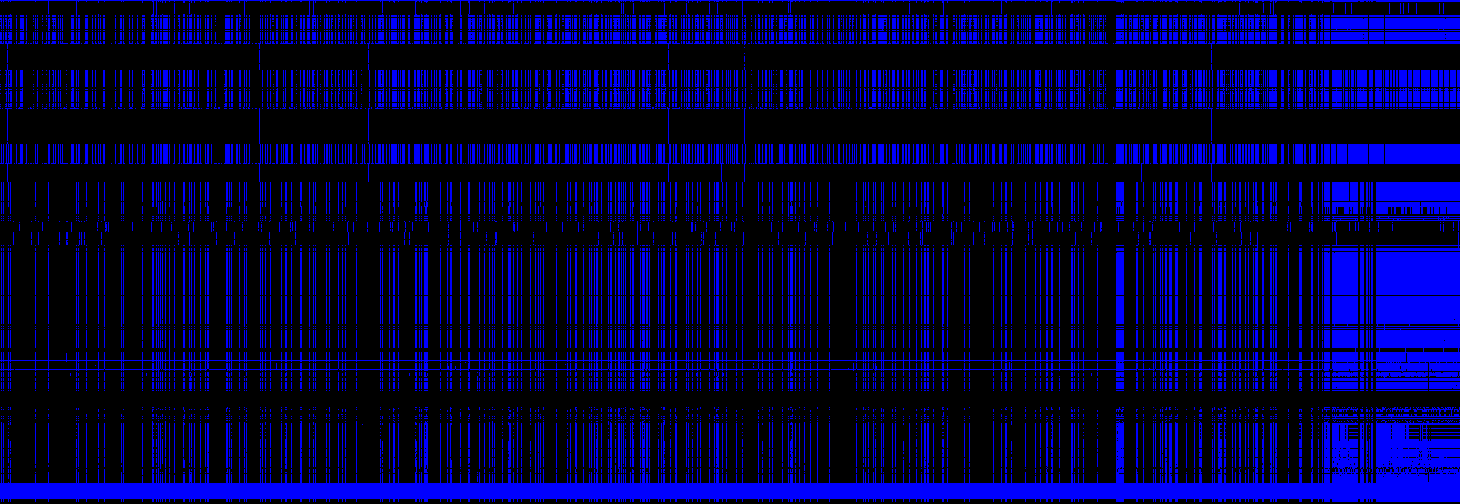

In [225]:
show()

In [226]:
#newly_filled.sum().sort_values(ascending=False)

In [227]:
#newly_filled.sum(axis=1).sort_values(ascending=False)

In [228]:
blue_count = newly_filled.sum().sum()

In [229]:
print( f"This merge newly filled {blue_count} cells, or { (blue_count*100)/(n_rows*n_cols):0.2f}% of Wave 5")

This merge newly filled 804663 cells, or 23.85% of Wave 5


## Step 2: Red

### Columns and rows we had before: Newly Empty

In [230]:
newly_empty = ~pd.isnull( old_wave5 ) & pd.isnull( new_wave5 )

In [231]:
( newly_filled & newly_empty).sum().sum()

0

### Need to examine these columns, why are they empty since the last upload?

In [232]:
#pd.set_option( 'max_rows', None)

In [233]:
newly_empty.sum().sort_values(ascending=False).head(20)

ecgQTC                             2261
examBisKidneyNotes                 1434
SphHRVFirstM_DIFF                   726
SphPWVFirstM_DIFF                   720
SphPWAFirstM_DIFF                   604
labsTSH                             499
labsFt4                             493
labsInsulinemia                     493
labsCRP                             206
SphHRVFirstM_RMS_SDD                193
SphHRVFirstM_STANDARD_DEVIATION     193
SphHRVFirstM_HRV_INDEX              192
SphHRVFirstM_TRIANGULAR_INDEX       192
labsPcrhs                            48
labsFibrinogeno                      46
labsMicroalubumina                   46
labsProteinuria                      46
labsCreurine                         45
labsVES                              37
labsFerritina                        34
dtype: int64

In [234]:
newly_empty.sum(axis=1).sort_values(ascending=False).head(20)

id_individual  Wave
28339          5       63
4844           5       63
21337          5       63
7781           5       55
684            5       52
11715          5       52
26069          5       52
5711           5       52
28745          5       52
2730           5       51
33381          5       51
21822          5       51
24332          5       50
38637          5       49
12895          5       49
1591           5       48
21832          5       48
12776          5       48
31529          5       37
5534           5       37
dtype: int64

In [235]:
#i = (684,5)

In [236]:
#newly_empty.loc[i, newly_empty.loc[i]].sort_index()

In [237]:
newly_empty.sum().sum()

10169

In [238]:
print( f"This merge newly EMPTIED {newly_empty.sum().sum()} cells, or { (newly_empty.sum().sum()*100)/(n_rows*n_cols):0.2f}% of Wave 5")

This merge newly EMPTIED 10169 cells, or 0.30% of Wave 5


In [239]:
img[:,:,0] = newly_empty

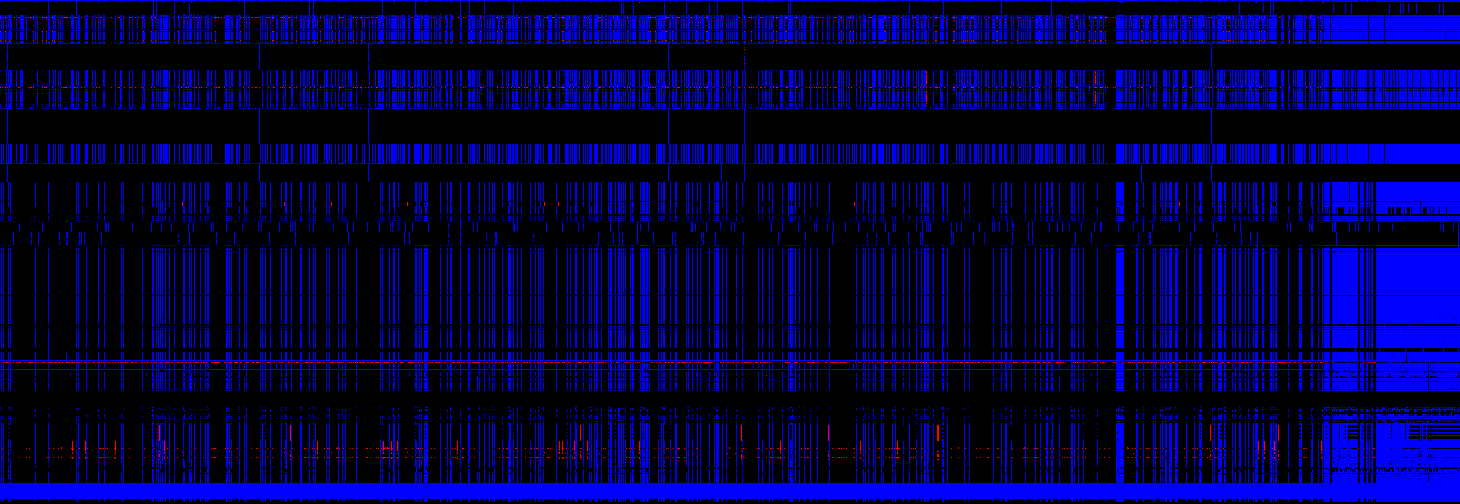

In [240]:
show()

## Step 3: Yellow

Col and rows we had before: Check equality

Yellow has RGB values R=1, G=1, B=0.

In [241]:
new_wave5.dtypes.value_counts()

float64           1008
object              65
datetime64[ns]       4
int64                2
dtype: int64

#### WARNING: ORDER MAY CHANGE ON SUBSEQUENT RUNS, COMPARE ABOVE AND BELOW CELL

In [243]:
float_t, object_t, datetime_t, int_t = new_wave5.dtypes.value_counts().index

In [244]:
float_t

dtype('float64')

### Step 3A: Convert everything to string and compare

In [245]:
old_wave5_asstring = old_wave5.astype( str )
new_wave5_asstring = new_wave5.astype( str )

In [246]:
string_cell_matches = old_wave5_asstring == new_wave5_asstring

## Step 3B: for numeric types, use isclose for comparison

In [247]:
old_wave5_numeric = old_wave5.transform( pd.to_numeric, errors='coerce' )
new_wave5_numeric = new_wave5.transform( pd.to_numeric, errors='coerce' )

In [248]:
float_cell_matches = np.isclose( old_wave5_numeric, new_wave5_numeric, rtol=0.01, equal_nan=True )

In [249]:
cell_mismatches = ~newly_filled & ~newly_empty & ~string_cell_matches & ~float_cell_matches

In [250]:
cell_mismatches.sum().sum()

17016

In [251]:
cell_mismatches.sum()[ cell_mismatches.sum() != 0]

Age                                  492
SphHRVFirstM_DP                        1
SphHRVFirstM_END_PULSE                 4
SphHRVFirstM_HF_MAXIMUM              155
SphHRVFirstM_HF_POWER                  4
SphHRVFirstM_HF_POWER_NORMALISED       4
SphHRVFirstM_LF_HF_RATIO               4
SphHRVFirstM_LF_MAXIMUM              193
SphHRVFirstM_LF_POWER                  4
SphHRVFirstM_LF_POWER_NORMALISED       3
SphHRVFirstM_MAX/MIN                   4
SphHRVFirstM_MAXIMUM                   3
SphHRVFirstM_MEAN                      2
SphHRVFirstM_MINIMUM                   4
SphHRVFirstM_MODE                      4
SphHRVFirstM_NN50                      3
SphHRVFirstM_NUMBER_PULSES             4
SphHRVFirstM_N_Measurements            3
SphHRVFirstM_PNN50                    28
SphHRVFirstM_RANGE                     4
SphHRVFirstM_SP                        1
SphHRVFirstM_SPECTRUM_MAXIMUM          3
SphHRVFirstM_START_TIME             1403
SphHRVFirstM_TOTAL_POWER               4
SphHRVFirstM_dat

In [252]:
img[:,:,0] |= cell_mismatches
img[:,:,1] |= cell_mismatches

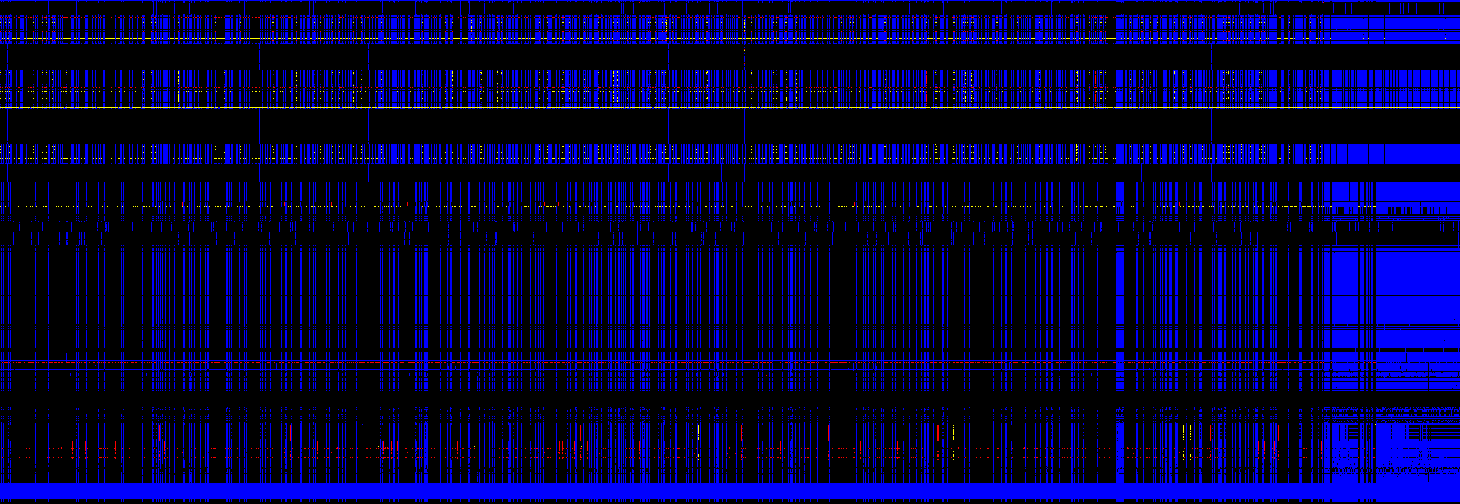

In [253]:
show()

### Need to examine these, why don't they match?

In [254]:
discrepancies_by_col = cell_mismatches.sum()[ cell_mismatches.sum() != 0].sort_values(ascending=False)

In [255]:
discrepancies_by_col

SphPWVFirstM_data visita 5     3119
SphPWAFirstM_data visita 5     2974
SphHRVFirstM_data visita 5     2602
id_mad                         1668
SphHRVFirstM_START_TIME        1403
SphPWVFirstM_N_Measurements     711
Visit                           634
Age                             492
SphPWAFirstM_N_Measurements     406
SphHRVFirstM_LF_MAXIMUM         193
SphHRVFirstM_HF_MAXIMUM         155
SphPWVFirstM_B_ECG_QC_PLV       147
SphPWVFirstM_A_ECG_QC_PLV       143
SphPWAFirstM_P_QC_PHV           140
SphPWAFirstM_P_QC_PLV           139
SphPWAFirstM_P_QC_DV            139
SphPWVFirstM_A_ECG_QC_PHV       134
SphPWVFirstM_B_ECG_QC_PHV       124
SphPWVFirstM_B_TON_QC_PLV       124
SphPWVFirstM_A_TON_QC_PLV       120
SphPWAFirstM_C_AP               101
SphPWVFirstM_PWVERR              91
SphPWAFirstM_C_AL                88
SphPWVFirstM_B_TON_QC_PHV        67
SphPWVFirstM_A_TON_QC_PHV        62
SphPWAFirstM_C_AGPH              61
SphPWAFirstM_C_P1_HEIGHT         51
SphPWAFirstM_C_T1ED         

In [256]:
def CompareOldAndNew( col_name, truth_table, max_comparisons=40 ):
    discrepancies = truth_table[col_name]
    discrepancies = discrepancies[ discrepancies == True ]
    desired_rows = sorted(list(discrepancies.index))[:max_comparisons]
    old_values = old_wave5.reindex( index=desired_rows, columns=[col_name] ).squeeze()
    new_values = new_wave5.reindex( index=desired_rows, columns=[col_name] ).squeeze()

    data = {}
    data[ 'VALUESEQUAL' ] = old_values == new_values
    data[ "OLDTYPE" ] = [type(_) for _ in list( old_values )]
    data[ "NEWTYPE" ] = [type(_) for _ in list( new_values )]
    data[ 'OLD'+col_name ] = old_values
    data[ 'NEW'+col_name ] = new_values
    data[ 'OBJSEQUAL' ] = old_values.astype(str) == new_values.astype(str)
    data = pd.DataFrame( index=desired_rows, data=data )
    return data[ data[ 'OBJSEQUAL' ] == False ]

In [257]:
diffs = iter( list( discrepancies_by_col.index))

### Notes

* id_individual 2025 Wave 5 changed?
* check sphygmocor id_individual 2206
* age in new release was converted to integer and rounded in a weird way
* labsWBC
* labsPLT

In [ ]:
CompareOldAndNew( next(diffs), cell_mismatches )

# Step 4 (optional): Add green for where everything checks out

In [259]:
cell_matches = ~newly_filled & ~newly_empty & ( string_cell_matches | float_cell_matches )

In [260]:
match_sum = cell_matches.sum().sum()

In [261]:
print( f"Matching cells={match_sum}, {match_sum*100/(n_rows*n_cols):0.1f}%")

Matching cells=2542185, 75.3%


In [262]:
img[:,:,1] |= cell_matches

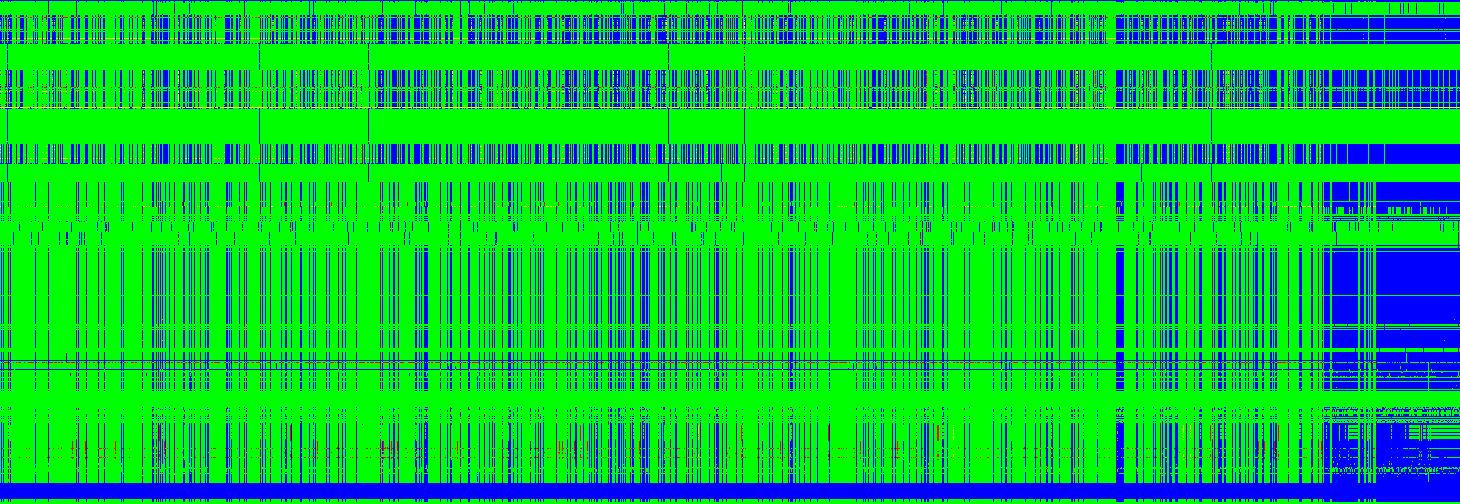

In [263]:
show()

In [264]:
plt.savefig( '20190123_WaveV_comparison_figure.png')

<Figure size 432x288 with 0 Axes>

### Notes:

* id individual 95 is consistently off

#### Unresolved
1. id_mad
2. Age changed by up to 0.6 years, some round up some round down

# Convert all numeric values to strings and lop off .0's, etc

In [265]:
new_prf = new_prf.astype(str)

In [266]:
new_prf.replace( to_replace='nan', value='', inplace=True, regex=False )

In [267]:
new_prf.replace( to_replace='NaT', value='', inplace=True, regex=False )

In [268]:
new_prf.replace( regex=True, inplace=True, to_replace=r'\.0+$', value='')

In [269]:
# round down
new_prf.replace( regex=True, inplace=True, to_replace=r'\.?00000+\d*$', value='')

# Write Putative New DB to file

In [270]:
new_prf.to_csv( '20190123_SardiNIA_WaveI-V.txt', sep='\t', encoding='utf-8', index=False )

In [271]:
new_prf.Wave.value_counts()

1    6165
2    5256
3    4842
4    4705
5    3127
Name: Wave, dtype: int64

In [ ]:
us_db_description.shape

In [ ]:
us_db_description = us_db_description \
    .set_index( 'Column Name') \
    .reindex( index=sorted_columns ) \
    .reset_index()

In [ ]:
us_db_description.shape

In [ ]:
us_db_description.head()

In [ ]:
us_db_description.to_excel( '20190122-Sardinia-Data-Description.xlsx', index=None, engine='openpyxl')

In [ ]:
ls -lrth 

In [ ]:
print( f"Notebook completed run in {(time.time()-t00)/60:0.1f} minutes.")